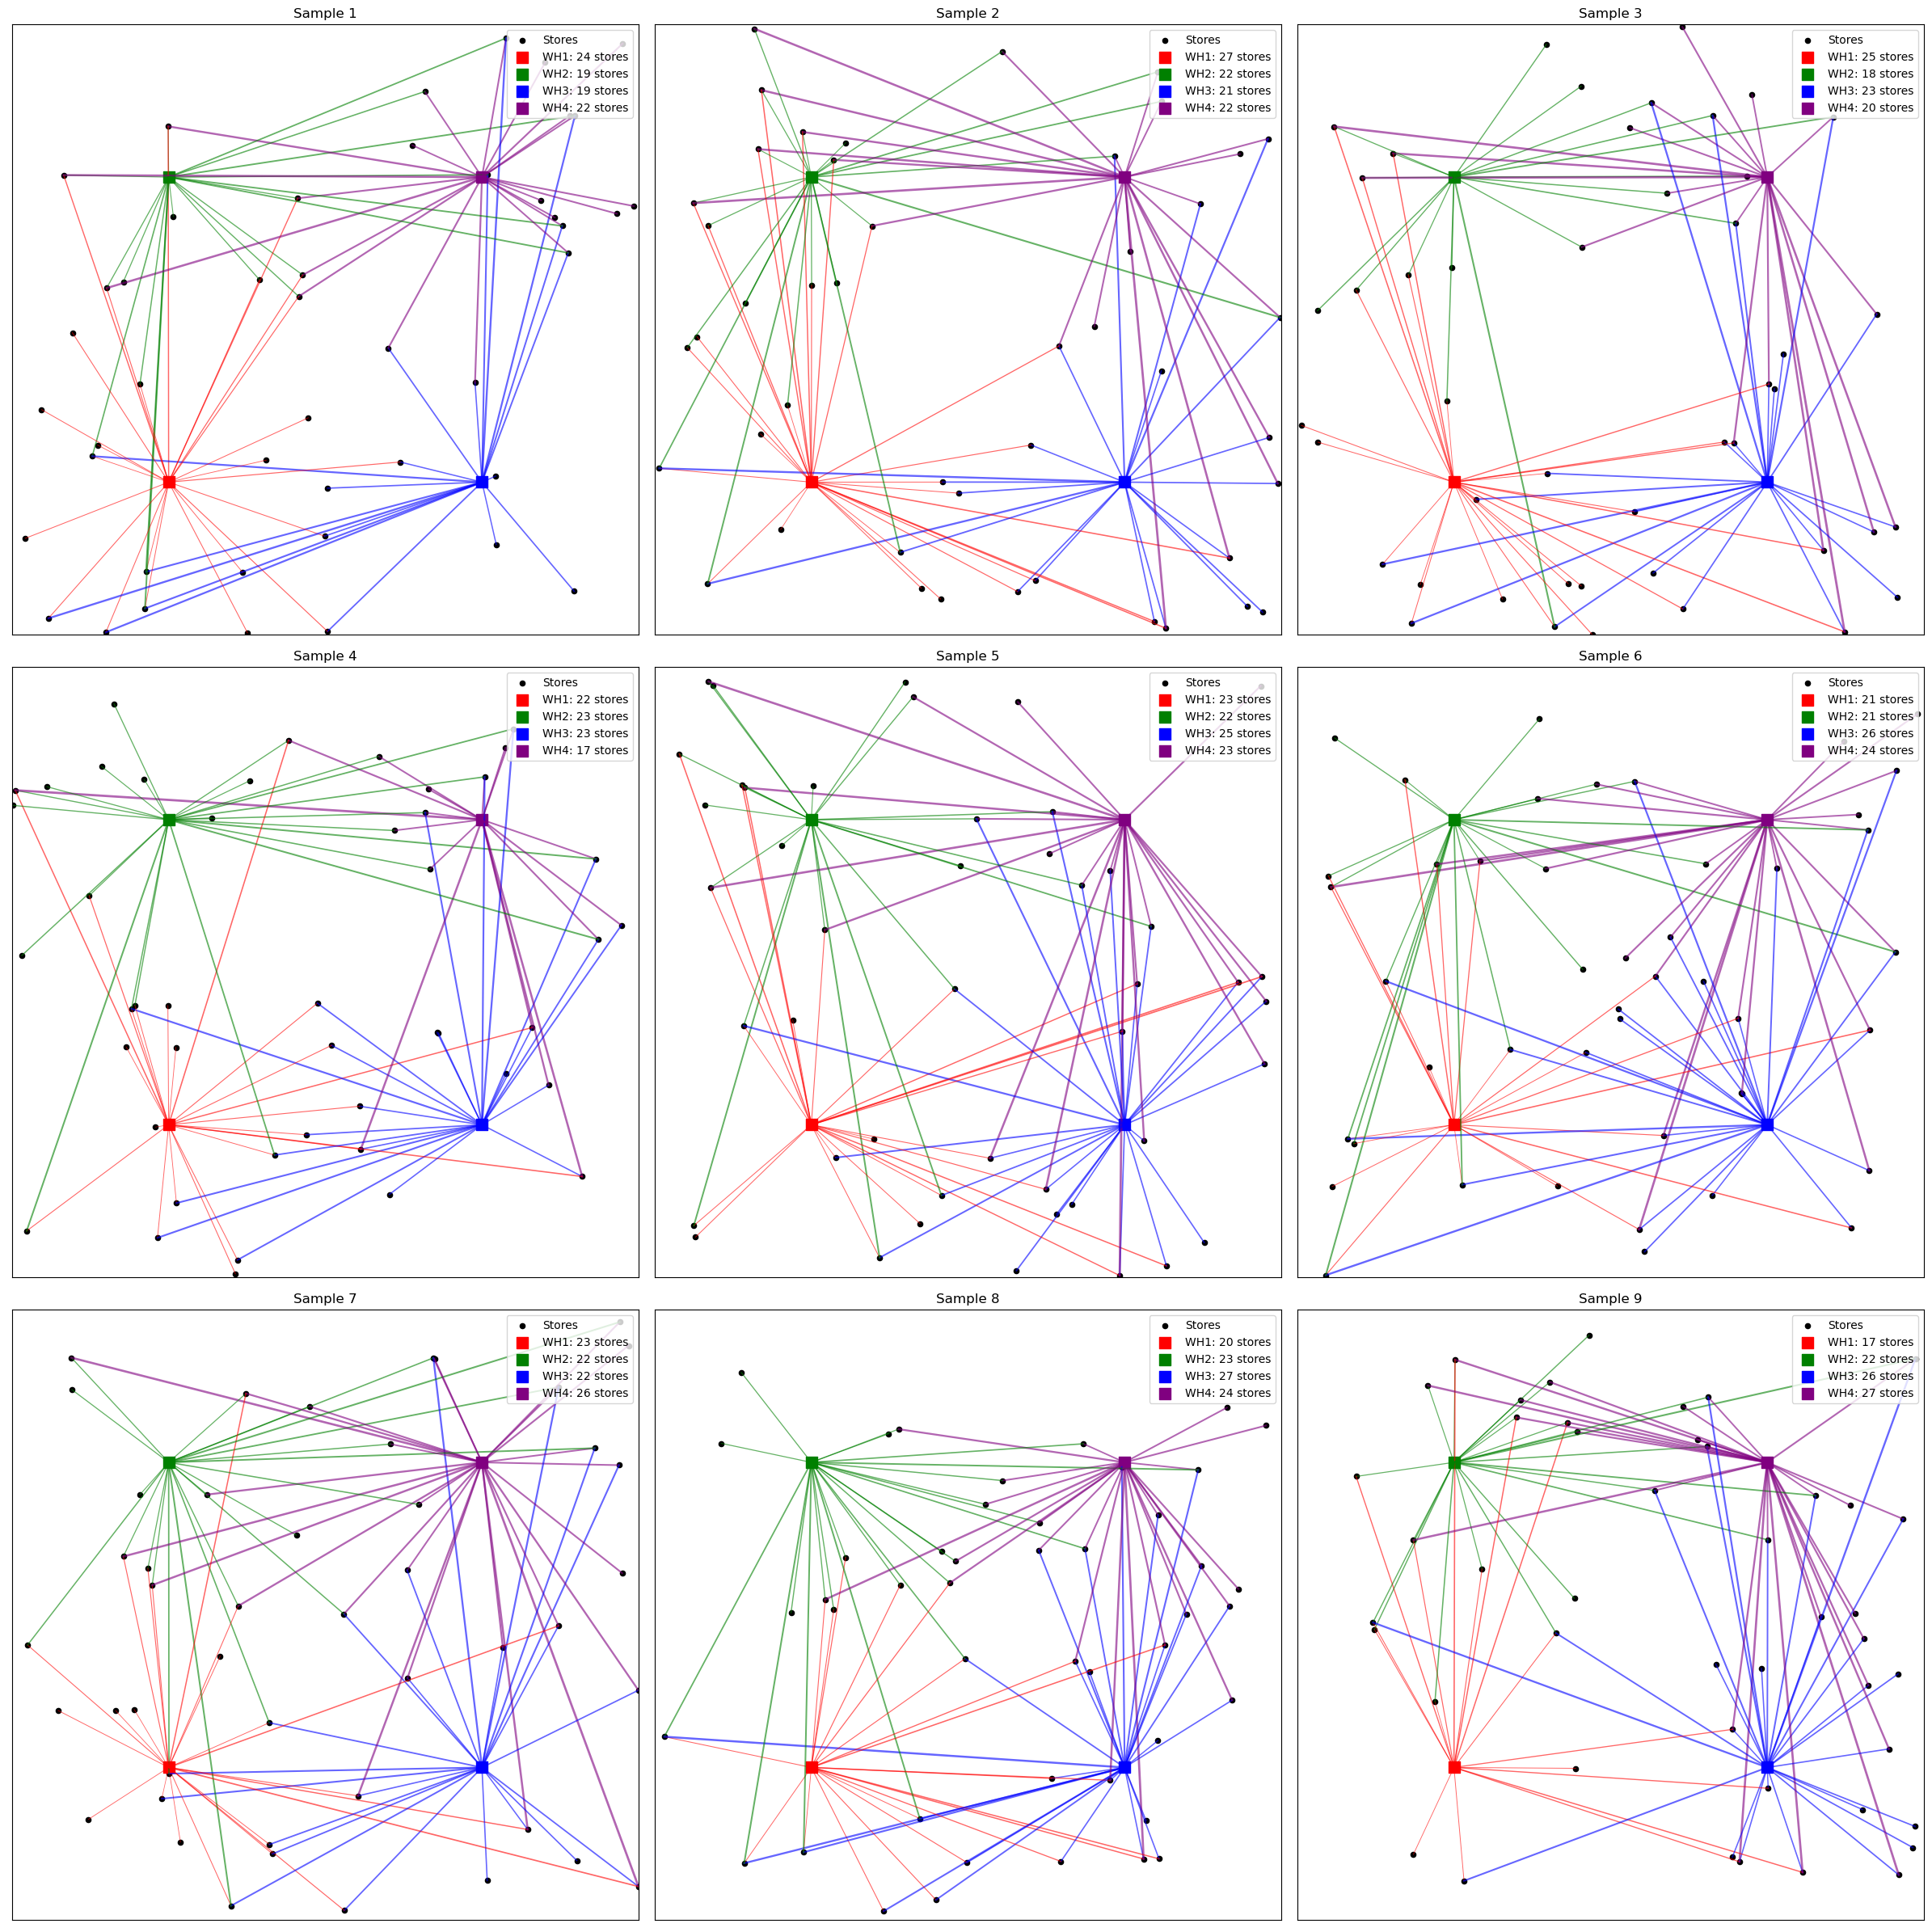

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial import distance

# Define parameters
num_stores = 46
num_warehouses = 4
warehouse_locations = np.array([
    [0.25, 0.25], [0.25, 0.75], [0.75, 0.25], [0.75, 0.75]
])

# Sample 9 different configurations
fig, axes = plt.subplots(3, 3, figsize=(24, 24))
axes = axes.ravel()

# Define colors for each warehouse
warehouse_colors = ['red', 'green', 'blue', 'purple']

for plot_idx in range(9):
    # Generate store locations uniformly
    store_locations = np.random.rand(num_stores, 2)
    
    # Fixed warehouse parameters
    additional_lead_time_stores = np.array([1.0, 1.5, 2.0, 2.5])  # Adjust per warehouse
    scaling_factor = 2.0  # To keep lead times reasonable
    
    # Compute distances from warehouses to stores
    distance_matrix = distance.cdist(warehouse_locations, store_locations)
    max_distance = np.max(distance_matrix)
    
    # Compute lead times from each warehouse to each store
    lead_times = additional_lead_time_stores[:, None] + (scaling_factor * distance_matrix / max_distance)
    
    # Connect each store to a random number (2 to 4) of closest warehouses
    connections = []
    warehouse_connections = [0] * num_warehouses  # Count connections per warehouse
    for i in range(num_stores):
        num_connections = np.random.randint(1, 4)  # 2 to 4 connections
        closest_warehouses = np.argsort(distance_matrix[:, i])[:num_connections]
        for w in closest_warehouses:
            connections.append((warehouse_locations[w], store_locations[i], lead_times[w, i], w))
            warehouse_connections[w] += 1
    
    # Set up subplot
    ax = axes[plot_idx]
    ax.set_xlim(0, 1)
    ax.set_ylim(0, 1)
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_title(f"Sample {plot_idx + 1}")
    
    # Plot stores
    ax.scatter(store_locations[:, 0], store_locations[:, 1], c='black', label='Stores', s=20)
    
    # Plot warehouses with connection counts in legend
    for w in range(num_warehouses):
        ax.scatter(warehouse_locations[w, 0], warehouse_locations[w, 1], c=warehouse_colors[w],
                  label=f'WH{w+1}: {warehouse_connections[w]} stores', s=100, marker='s')
    
    # Plot connections with thickness based on lead time and color based on warehouse
    for (wh, st, lt, w) in connections:
        ax.plot([wh[0], st[0]], [wh[1], st[1]], color=warehouse_colors[w], alpha=0.6, linewidth=lt/2)
    
    # Add legend inside the plot in upper right
    ax.legend(loc='upper right')

plt.tight_layout()
plt.show()

Filtered to 20 stores
Total selected stores: 20

Setting with 1 warehouse(s):

Edges matrix:
[[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]]

Lead times matrix:
[[3. 3. 3. 3. 3. 3. 2. 3. 3. 4. 3. 4. 3. 3. 3. 3. 3. 3. 2. 3.]]
 Warehouse 0: #Stores = 20, Connected stores = 20

Setting with 2 warehouse(s):

Edges matrix:
[[1. 1. 1. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 1. 0. 1. 1. 1. 1. 1. 1. 1. 1.]]

Lead times matrix:
[[4. 4. 4. 4. 2. 2. 2. 2. 2. 3. 2. 2. 4. 4. 4. 4. 4. 4. 3. 2.]
 [2. 2. 2. 2. 3. 3. 3. 3. 3. 4. 3. 4. 2. 2. 2. 2. 2. 2. 3. 3.]]
 Warehouse 0: #Stores = 9, Connected stores = 19
 Warehouse 1: #Stores = 11, Connected stores = 18

Setting with 3 warehouse(s):

Edges matrix:
[[1. 1. 1. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1. 1. 1. 0. 0. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1.]
 [0. 0. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1. 0. 0. 0. 0. 0. 0. 1. 1.]]

Lead times matrix:
[[4. 3. 4. 4. 2. 2. 2. 2. 3. 4. 3. 3

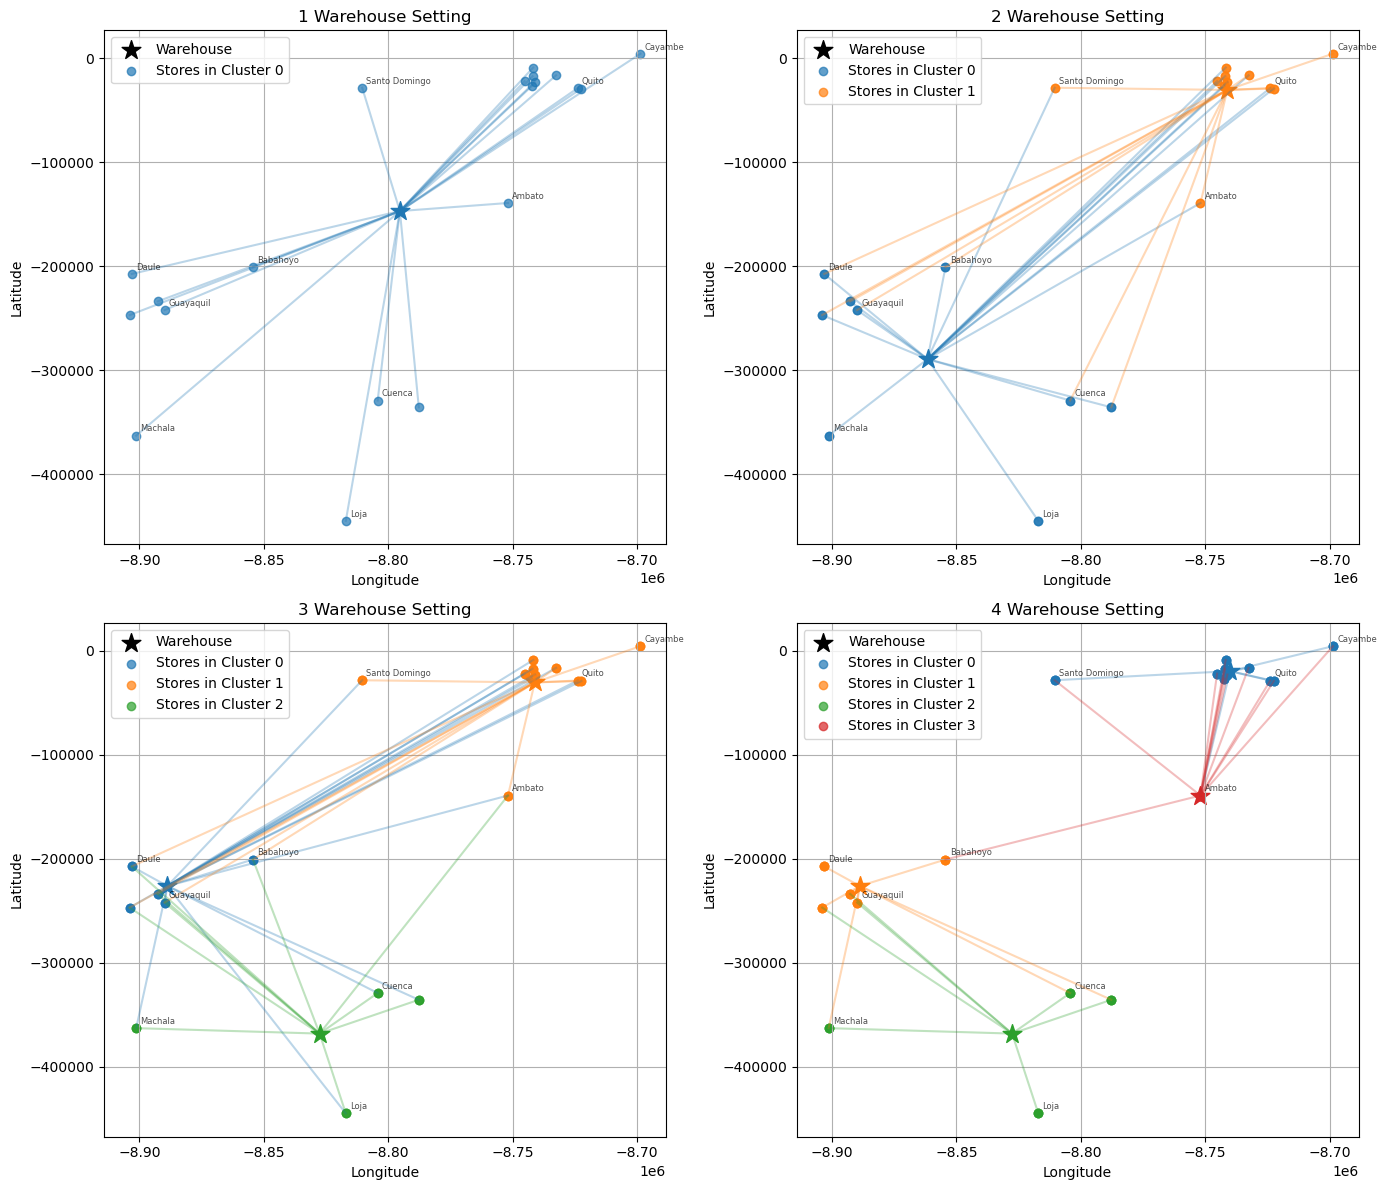

In [2]:
import pandas as pd
import numpy as np
import random
import math
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans

# -----------------------------
# 1. Define store data and selection
# -----------------------------

# Create a DataFrame for the 54 stores
data = [
    [1, "Quito", "Pichincha", "D", 13],
    [2, "Quito", "Pichincha", "D", 13],
    [3, "Quito", "Pichincha", "D", 8],
    [4, "Quito", "Pichincha", "D", 9],
    [5, "Santo Domingo", "Santo Domingo de los Tsachilas", "D", 4],
    [6, "Quito", "Pichincha", "D", 13],
    [7, "Quito", "Pichincha", "D", 8],
    [8, "Quito", "Pichincha", "D", 8],
    [9, "Quito", "Pichincha", "B", 6],
    [10, "Quito", "Pichincha", "C", 15],
    [11, "Cayambe", "Pichincha", "B", 6],
    [12, "Latacunga", "Cotopaxi", "C", 15],
    [13, "Latacunga", "Cotopaxi", "C", 15],
    [14, "Riobamba", "Chimborazo", "C", 7],
    [15, "Ibarra", "Imbabura", "C", 15],
    [16, "Santo Domingo", "Santo Domingo de los Tsachilas", "C", 3],
    [17, "Quito", "Pichincha", "C", 12],
    [18, "Quito", "Pichincha", "B", 16],
    [19, "Guaranda", "Bolivar", "C", 15],
    [20, "Quito", "Pichincha", "B", 6],
    [21, "Santo Domingo", "Santo Domingo de los Tsachilas", "B", 6],
    [22, "Puyo", "Pastaza", "C", 7],
    [23, "Ambato", "Tungurahua", "D", 9],
    [24, "Guayaquil", "Guayas", "D", 1],
    [25, "Salinas", "Santa Elena", "D", 1],
    [26, "Guayaquil", "Guayas", "D", 10],
    [27, "Daule", "Guayas", "D", 1],
    [28, "Guayaquil", "Guayas", "E", 10],
    [29, "Guayaquil", "Guayas", "E", 10],
    [30, "Guayaquil", "Guayas", "C", 3],
    [31, "Babahoyo", "Los Rios", "B", 10],
    [32, "Guayaquil", "Guayas", "C", 3],
    [33, "Quevedo", "Los Rios", "C", 3],
    [34, "Guayaquil", "Guayas", "B", 6],
    [35, "Playas", "Guayas", "C", 3],
    [36, "Libertad", "Guayas", "E", 10],
    [37, "Cuenca", "Azuay", "D", 2],
    [38, "Loja", "Loja", "D", 4],
    [39, "Cuenca", "Azuay", "B", 6],
    [40, "Machala", "El Oro", "C", 3],
    [41, "Machala", "El Oro", "D", 4],
    [42, "Cuenca", "Azuay", "D", 2],
    [43, "Esmeraldas", "Esmeraldas", "E", 10],
    [44, "Quito", "Pichincha", "A", 5],
    [45, "Quito", "Pichincha", "A", 11],
    [46, "Quito", "Pichincha", "A", 14],
    [47, "Quito", "Pichincha", "A", 14],
    [48, "Quito", "Pichincha", "A", 14],
    [49, "Quito", "Pichincha", "A", 11],
    [50, "Ambato", "Tungurahua", "A", 14],
    [51, "Guayaquil", "Guayas", "A", 17],
    [52, "Manta", "Manabi", "A", 11],
    [53, "Manta", "Manabi", "D", 13],
    [54, "El Carmen", "Manabi", "C", 3]
]
columns = ["store_nbr", "city", "state", "type", "cluster"]
stores_df = pd.DataFrame(data, columns=columns)

max_distance_multipliers = [2.5, 2.0, 2.5,2.0]
max_overall_clusters = True

# Filter stores_df to keep only the specified store numbers
stores_to_keep = [3, 5, 8, 11, 27, 28, 31, 34, 37, 38, 39, 41, 44, 45, 46, 47, 48, 49, 50, 51]
stores_df = stores_df[stores_df['store_nbr'].isin(stores_to_keep)].reset_index(drop=True)
print(f"Filtered to {len(stores_df)} stores")

# Group stores by city
city_groups = stores_df.groupby("city")
# Find cities with >1 store (multi-store) and with exactly 1 store (single-store)
multi_store_cities = [city for city, group in city_groups if len(group) > 1]
single_store_cities = [city for city, group in city_groups if len(group) == 1]

# Use all stores since data already has 46 stores
selected_stores = stores_df.reset_index(drop=True)
print("Total selected stores:", len(selected_stores))


# -----------------------------
# 2. Assign random coordinates based on city centers
# -----------------------------
# Original dictionary: keys are city names, values are (lon, lat) tuples
city_coords = {
    "Esmeraldas": (-79.6545, 0.9682),
    "Ibarra": (-78.1165, 0.3517),
    "Cayambe": (-78.1416, 0.0412),
    "Quito": (-78.4678, -0.1807),
    "Santo Domingo": (-79.1459, -0.253),
    "Manta": (-80.7214, -0.9682),
    "Latacunga": (-78.6131, -0.9352),
    "El Carmen": (-79.8413, -0.3944),
    "Quevedo": (-79.4632, -1.0281),
    "Puyo": (-78.0035, -1.4921),
    "Ambato": (-78.6197, -1.2491),
    "Riobamba": (-78.6546, -1.6636),
    "Babahoyo": (-79.5400, -1.8022),
    "Daule": (-79.9775, -1.8619),
    "Guayaquil": (-79.8891, -2.1709),
    "Libertad": (-80.9182, -2.2333),
    "Playas": (-80.3895, -2.6333),
    "Salinas": (-80.9607, -2.2117),
    "Cuenca": (-79.0059, -2.9006),
    "Machala": (-79.9616, -3.2581),
    "Loja": (-79.2050, -3.9931),
    "Guaranda": (-79.0000, -1.5900),
}


def latlon_to_mercator(lon, lat):
    """
    Convert longitude and latitude (in degrees) to x, y coordinates 
    in the Web Mercator projection (in meters).
    """
    R = 6378137  # Earth's radius in meters for Web Mercator
    x = R * math.radians(lon)
    y = R * math.log(math.tan(math.pi/4 + math.radians(lat)/2))
    return x, y

# Convert the dictionary of city centers to Web Mercator (x, y) coordinates
mercator_coords = {city: latlon_to_mercator(lon, lat) for city, (lon, lat) in city_coords.items()}
# Mirror coordinates by y=x axis by swapping x and y coordinates
mercator_coords = {city: (y, x) for city, (x, y) in mercator_coords.items()}

city_coords = mercator_coords


rng = np.random.RandomState(5)  # Fixed seed for reproducibility
# Function to add random noise (simulate dispersion within a city's area)
def random_location(city, noise=15000):  # noise in meters for mercator coords
    if city in city_coords:
        base_x, base_y = city_coords[city]
        # Only add noise if city has multiple stores
        if city in multi_store_cities:
            # add uniform noise in x and y coordinates with fixed seed
            x = base_x + rng.uniform(-noise, noise)
            y = base_y + rng.uniform(-noise, noise)
        else:
            # Use exact city coordinates for single-store cities
            x, y = base_x, base_y
        return x, y
    else:
        # if city not in lookup, return NaN
        return np.nan, np.nan

# Assign random lat, lon for each selected store
lats, lons = [], []
for idx, row in selected_stores.iterrows():
    lat, lon = random_location(row["city"])
    lats.append(lat)
    lons.append(lon)
selected_stores["lat"] = lats
selected_stores["lon"] = lons

# -----------------------------
# 3. Define haversine distance function
# -----------------------------
def haversine(x1, y1, x2, y2):
    # Since coordinates are already in Web Mercator projection (meters)
    # We can use Euclidean distance and convert to kilometers
    dx = x2 - x1
    dy = y2 - y1
    distance_meters = math.sqrt(dx**2 + dy**2)
    return distance_meters / 1000  # Convert to kilometers

# -----------------------------
# 4. Clustering, cost and lead time computations and plotting
# -----------------------------

# Primitive parameters
h0, h1 = 0.2, 0.4  # warehouse holding cost range
dl0, dl1 = 1, 2    # distance lead time range

# Create a figure with 4 subplots for 1, 2, 3, and 4 warehouses
fig, axes = plt.subplots(2, 2, figsize=(14, 12))
axes = axes.flatten()

# We'll work on the numpy array of store coordinates
coords = selected_stores[["lat", "lon"]].values

# For each setting (number of warehouses = k)
for i, k in enumerate([1, 2, 3, 4]):
    ax = axes[i]
    max_distance_multiplier = max_distance_multipliers[i]
    # Run k-means clustering
    kmeans = KMeans(n_clusters=k, random_state=42)
    labels = kmeans.fit_predict(coords)
    centers = kmeans.cluster_centers_
    
    # Append cluster labels to DataFrame copy
    stores_clustered = selected_stores.copy()
    stores_clustered["cluster"] = labels
    
    # Determine number of stores per cluster
    cluster_counts = stores_clustered.groupby("cluster").size()
    min_count = cluster_counts.min()
    max_count = cluster_counts.max()
    
    # For printing warehouse info
    warehouse_info = []
    
    # Calculate max distances for each cluster
    max_distances = []
    for cluster in range(k):
        cluster_stores = stores_clustered[stores_clustered["cluster"] == cluster]
        center_lat, center_lon = centers[cluster]
        # Calculate distances from center to all points in cluster
        distances = [haversine(center_lat, center_lon, store["lat"], store["lon"]) 
                    for _, store in cluster_stores.iterrows()]
        # Get the maximum distance
        max_dist = max(distances) if distances else 0
        max_distances.append(max_dist)
    
    # Initialize edges and lead times matrices
    edges = np.zeros((k, len(stores_clustered)))
    lead_times = np.zeros((k, len(stores_clustered)))
    
    # For each warehouse (cluster)
    for cluster in range(k):
        cluster_stores = stores_clustered[stores_clustered["cluster"] == cluster]
        w_n = len(cluster_stores)
        # Compute normalized weight: if max_count==min_count then weight=1
        if max_count != min_count:
            w_k = (w_n - min_count) / (max_count - min_count)
        else:
            w_k = 1.0
        
        # Compute distances of each store in cluster from warehouse center
        center_lat, center_lon = centers[cluster]
        distances = []
        for idx, store in stores_clustered.iterrows():
            d = haversine(center_lat, center_lon, store["lat"], store["lon"])
            distances.append(d)
            
            # Check if store is within max distance * multiplier
            if max_overall_clusters:
                max_d = max(max_distances)
            else:
                max_d = max_distances[cluster]
            if d <= max_d * max_distance_multiplier:
                edges[cluster][idx] = 1
                
        # Determine min and max distance in this cluster (for normalization)
        if distances:
            min_d = min(distances)
            max_d = max(distances)
        else:
            min_d, max_d = 0, 0
        
        # For each distance, compute lead time based only on distance
        for idx, d in enumerate(distances):
            if max_d != min_d:
                norm_d = (d - min_d) / (max_d - min_d)
            else:
                norm_d = 0
                
            lead_time = dl0 + (dl1 - dl0) * norm_d
            lead_times[cluster][idx] = np.round(lead_time)
        
        warehouse_info.append({
            "warehouse": cluster,
            "stores": w_n,
            "w_k": w_k
        })

    
    # Plotting: scatter plot for store locations colored by cluster, and mark warehouse centers.
    # First plot warehouse marker in legend
    ax.scatter([], [], c='black', marker='*', s=200, label='Warehouse')
    # Define colors for clusters - using a simpler color palette
    colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd',
              '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf',
              '#aec7e8', '#ffbb78', '#98df8a', '#ff9896', '#c5b0d5']
    
    # Plot connections and stores for each cluster
    connected_stores_count = [0] * k  # Initialize counter for each cluster
    
    for cluster in range(k):
        cluster_data = stores_clustered[stores_clustered["cluster"] == cluster]
        color = colors[cluster % len(colors)]  # Get color for this cluster
        center_lat, center_lon = centers[cluster]
        max_dist = max(max_distances)
        
        for _, store in stores_clustered.iterrows():
            dist = haversine(center_lat, center_lon, store["lat"], store["lon"])
            # Plot store
            store_color = colors[store["cluster"] % len(colors)]
            ax.scatter(store["lon"], store["lat"], 
                      color=store_color, alpha=0.7)
            
            # Draw connection line if within max distance
            if max_overall_clusters:
                max_d = max(max_distances)
            else:
                max_d = max_distances[cluster]
            if dist <= max_d * max_distance_multiplier:
                ax.plot([center_lon, store["lon"]], 
                       [center_lat, store["lat"]], 
                       color=color, alpha=0.3, linestyle='-')
                connected_stores_count[cluster] += 1
                
        # Plot warehouse center
        ax.scatter(center_lon, center_lat, c=color, marker="*", s=200)
        
        # Add cluster label to legend
        ax.scatter([], [], c=color, label=f"Stores in Cluster {cluster}", alpha=0.7)
        
        # Track cities already labeled in this cluster
        labeled_cities = set()
        # Add city names for each point
        for _, store in cluster_data.iterrows():
            if store["city"] not in labeled_cities:
                ax.annotate(store["city"], (store["lon"], store["lat"]), 
                           fontsize=6, alpha=0.7,
                           xytext=(3, 3), textcoords='offset points')
                labeled_cities.add(store["city"])
            
    ax.set_xlabel("Longitude")
    ax.set_ylabel("Latitude")
    ax.set_title(f"{k} Warehouse Setting")
    ax.legend()
    ax.grid(True)

    print(f"\nSetting with {k} warehouse(s):")
    print("\nEdges matrix:")
    print(edges)
    print("\nLead times matrix:")
    print(lead_times)
    for info, connected_count in zip(warehouse_info, connected_stores_count):
        print(f" Warehouse {info['warehouse']}: #Stores = {info['stores']}, "
                f"Connected stores = {connected_count}")

plt.tight_layout()
plt.show()


Total selected stores: 46

Setting with 1 warehouse(s):

Edges matrix:
[[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
  1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]]

Lead times matrix:
[[4. 4. 4. 4. 4. 3. 3. 3. 4. 4. 4. 4. 3. 4. 4. 4. 3. 4. 4. 4. 4. 4. 3. 4.
  3. 4. 4. 4. 4. 5. 4. 4. 5. 4. 5. 4. 4. 4. 4. 4. 4. 3. 4. 4. 4. 4.]]
 Warehouse 0: #Stores = 46, Connected stores = 46, min lead time(before distance lead time) = 2.00, holding cost = 0.30

Setting with 2 warehouse(s):

Edges matrix:
[[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 0. 1. 1. 1. 1. 1.
  1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1. 0. 0. 0. 1.]
 [0. 0. 0. 1. 0. 1. 1. 1. 0. 1. 0. 0. 1. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1.
  1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 1. 1.]]

Lead times matrix:
[[4. 4. 4. 4. 4. 4. 4. 5. 4. 4. 4. 4. 5. 4. 4. 5. 4. 5. 6. 5. 5. 5. 5. 5.
  5. 5. 6. 6. 5. 6. 5. 6. 6. 5. 5. 4. 4. 4. 4. 4. 4. 4. 5. 5. 5. 5.]
 [4. 4


Setting with 4 warehouse(s):

Edges matrix:
[[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 0. 0. 0. 0. 0. 0.
  1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 1. 0. 0. 0. 0. 1. 1. 1. 1. 1. 1. 1.
  1. 1. 1. 1. 1. 0. 1. 1. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 1. 0. 0. 0. 0.
  0. 0. 0. 0. 1. 1. 1. 1. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 1. 1. 1. 0. 0. 1. 1. 1. 0. 0. 1. 1. 0. 0. 0. 0. 0. 1. 0.
  1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 0. 0. 1. 1. 0. 0. 0. 0.]]

Lead times matrix:
[[4. 4. 4. 4. 4. 4. 4. 5. 4. 4. 4. 4. 5. 4. 4. 5. 5. 5. 6. 5. 5. 5. 5. 5.
  5. 5. 6. 6. 5. 6. 5. 6. 6. 5. 5. 4. 4. 4. 4. 4. 4. 5. 5. 5. 5. 5.]
 [5. 5. 5. 4. 5. 4. 4. 4. 5. 4. 5. 5. 4. 5. 4. 4. 4. 3. 3. 3. 3. 3. 3. 3.
  4. 3. 3. 3. 4. 4. 4. 4. 4. 4. 5. 5. 5. 5. 5. 5. 5. 4. 3. 4. 4. 4.]
 [3. 3. 3. 3. 4. 3. 3. 3. 4. 3. 3. 3. 3. 4. 3. 3. 3. 2. 3. 2. 3. 2. 3. 2.
  

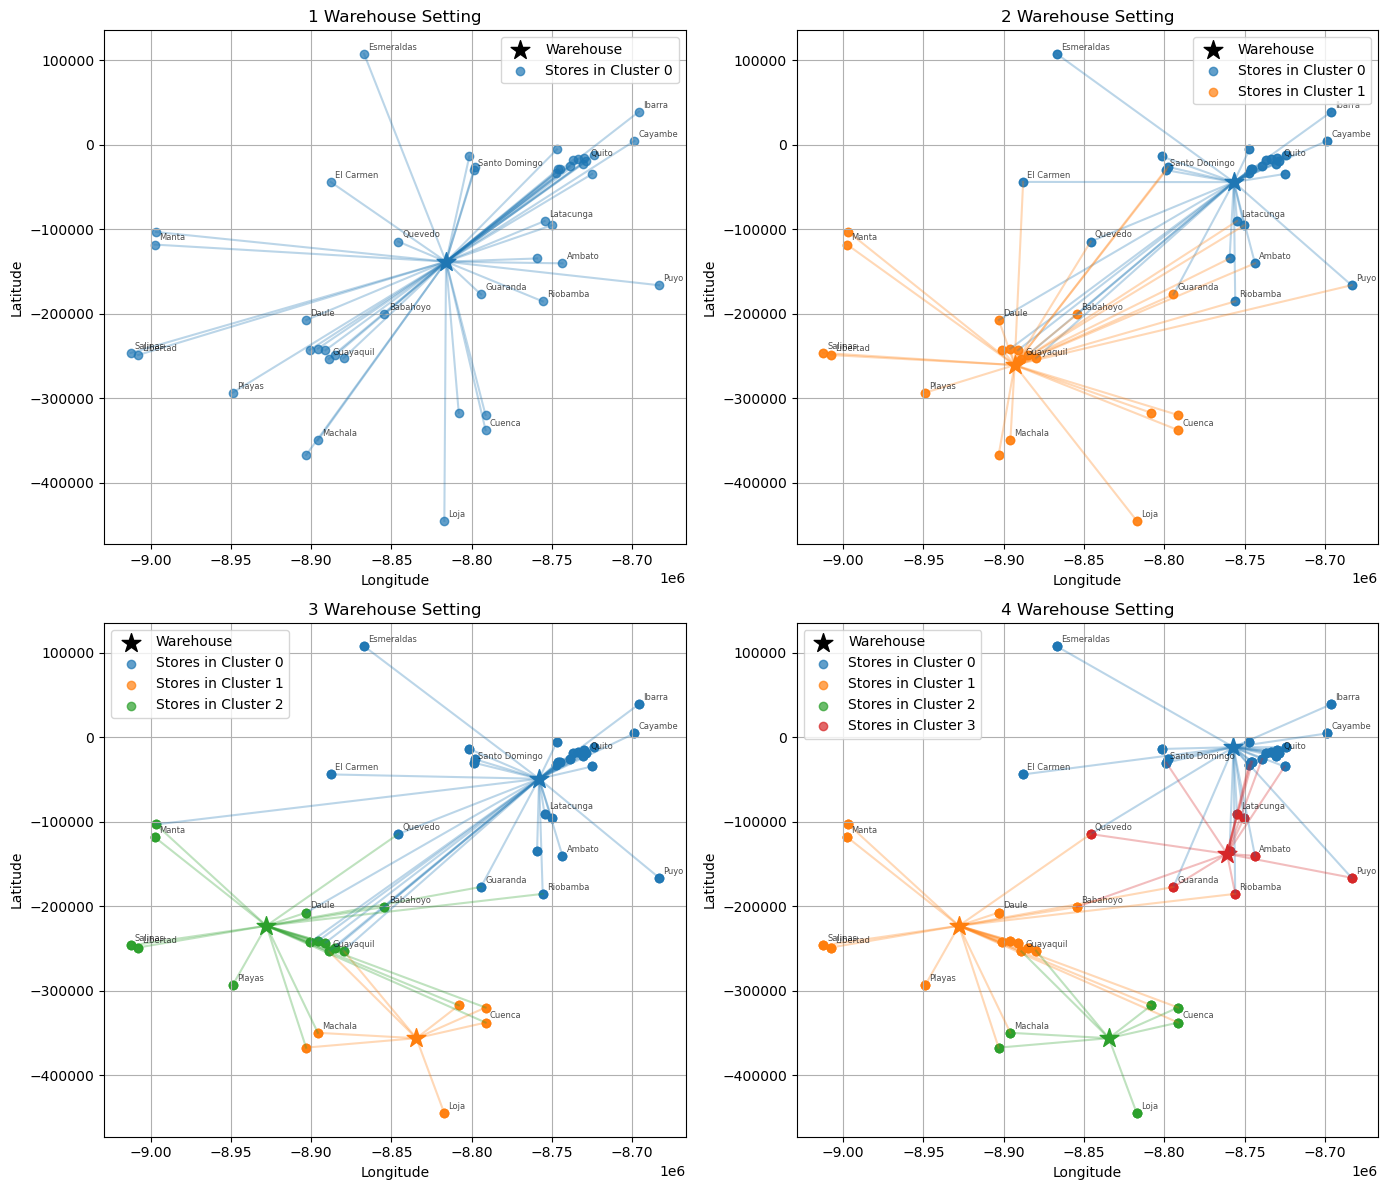

In [3]:
import pandas as pd
import numpy as np
import random
import math
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans

# -----------------------------
# 1. Define store data and selection
# -----------------------------

# Create a DataFrame for the 54 stores
data = [
    [1, "Quito", "Pichincha", "D", 13],
    [2, "Quito", "Pichincha", "D", 13],
    [3, "Quito", "Pichincha", "D", 8],
    [5, "Santo Domingo", "Santo Domingo de los Tsachilas", "D", 4],
    [11, "Cayambe", "Pichincha", "B", 6],
    [12, "Latacunga", "Cotopaxi", "C", 15],
    [13, "Latacunga", "Cotopaxi", "C", 15],
    [14, "Riobamba", "Chimborazo", "C", 7],
    [15, "Ibarra", "Imbabura", "C", 15],
    [16, "Santo Domingo", "Santo Domingo de los Tsachilas", "C", 3],
    [17, "Quito", "Pichincha", "C", 12],
    [18, "Quito", "Pichincha", "B", 16],
    [19, "Guaranda", "Bolivar", "C", 15],
    [20, "Quito", "Pichincha", "B", 6],
    [21, "Santo Domingo", "Santo Domingo de los Tsachilas", "B", 6],
    [22, "Puyo", "Pastaza", "C", 7],
    [23, "Ambato", "Tungurahua", "D", 9],
    [24, "Guayaquil", "Guayas", "D", 1],
    [25, "Salinas", "Santa Elena", "D", 1],
    [26, "Guayaquil", "Guayas", "D", 10],
    [27, "Daule", "Guayas", "D", 1],
    [30, "Guayaquil", "Guayas", "C", 3],
    [31, "Babahoyo", "Los Rios", "B", 10],
    [32, "Guayaquil", "Guayas", "C", 3],
    [33, "Quevedo", "Los Rios", "C", 3],
    [34, "Guayaquil", "Guayas", "B", 6],
    [35, "Playas", "Guayas", "C", 3],
    [36, "Libertad", "Guayas", "E", 10],
    [37, "Cuenca", "Azuay", "D", 2],
    [38, "Loja", "Loja", "D", 4],
    [39, "Cuenca", "Azuay", "B", 6],
    [40, "Machala", "El Oro", "C", 3],
    [41, "Machala", "El Oro", "D", 4],
    [42, "Cuenca", "Azuay", "D", 2],
    [43, "Esmeraldas", "Esmeraldas", "E", 10],
    [44, "Quito", "Pichincha", "A", 5],
    [45, "Quito", "Pichincha", "A", 11],
    [46, "Quito", "Pichincha", "A", 14],
    [47, "Quito", "Pichincha", "A", 14],
    [48, "Quito", "Pichincha", "A", 14],
    [49, "Quito", "Pichincha", "A", 11],
    [50, "Ambato", "Tungurahua", "A", 14],
    [51, "Guayaquil", "Guayas", "A", 17],
    [52, "Manta", "Manabi", "A", 11],
    [53, "Manta", "Manabi", "D", 13],
    [54, "El Carmen", "Manabi", "C", 3]
]
columns = ["store_nbr", "city", "state", "type", "cluster"]
stores_df = pd.DataFrame(data, columns=columns)

# Group stores by city
city_groups = stores_df.groupby("city")
# Find cities with >1 store (multi-store) and with exactly 1 store (single-store)
multi_store_cities = [city for city, group in city_groups if len(group) > 1]
single_store_cities = [city for city, group in city_groups if len(group) == 1]

# Use all stores since data already has 46 stores
selected_stores = stores_df.reset_index(drop=True)
print("Total selected stores:", len(selected_stores))


# -----------------------------
# 2. Assign random coordinates based on city centers
# -----------------------------
# Original dictionary: keys are city names, values are (lon, lat) tuples
city_coords = {
    "Esmeraldas": (-79.6545, 0.9682),
    "Ibarra": (-78.1165, 0.3517),
    "Cayambe": (-78.1416, 0.0412),
    "Quito": (-78.4678, -0.1807),
    "Santo Domingo": (-79.1459, -0.253),
    "Manta": (-80.7214, -0.9682),
    "Latacunga": (-78.6131, -0.9352),
    "El Carmen": (-79.8413, -0.3944),
    "Quevedo": (-79.4632, -1.0281),
    "Puyo": (-78.0035, -1.4921),
    "Ambato": (-78.6197, -1.2491),
    "Riobamba": (-78.6546, -1.6636),
    "Babahoyo": (-79.5400, -1.8022),
    "Daule": (-79.9775, -1.8619),
    "Guayaquil": (-79.8891, -2.1709),
    "Libertad": (-80.9182, -2.2333),
    "Playas": (-80.3895, -2.6333),
    "Salinas": (-80.9607, -2.2117),
    "Cuenca": (-79.0059, -2.9006),
    "Machala": (-79.9616, -3.2581),
    "Loja": (-79.2050, -3.9931),
    "Guaranda": (-79.0000, -1.5900),
}


def latlon_to_mercator(lon, lat):
    """
    Convert longitude and latitude (in degrees) to x, y coordinates 
    in the Web Mercator projection (in meters).
    """
    R = 6378137  # Earth's radius in meters for Web Mercator
    x = R * math.radians(lon)
    y = R * math.log(math.tan(math.pi/4 + math.radians(lat)/2))
    return x, y

# Convert the dictionary of city centers to Web Mercator (x, y) coordinates
mercator_coords = {city: latlon_to_mercator(lon, lat) for city, (lon, lat) in city_coords.items()}
# Mirror coordinates by y=x axis by swapping x and y coordinates
mercator_coords = {city: (y, x) for city, (x, y) in mercator_coords.items()}

city_coords = mercator_coords


rng = np.random.RandomState(0)  # Fixed seed for reproducibility
# Function to add random noise (simulate dispersion within a city's area)
def random_location(city, noise=15000):  # noise in meters for mercator coords
    if city in city_coords:
        base_x, base_y = city_coords[city]
        # Only add noise if city has multiple stores
        if city in multi_store_cities:
            # add uniform noise in x and y coordinates with fixed seed
            x = base_x + rng.uniform(-noise, noise)
            y = base_y + rng.uniform(-noise, noise)
        else:
            # Use exact city coordinates for single-store cities
            x, y = base_x, base_y
        return x, y
    else:
        # if city not in lookup, return NaN
        return np.nan, np.nan

# Assign random lat, lon for each selected store
lats, lons = [], []
for idx, row in selected_stores.iterrows():
    lat, lon = random_location(row["city"])
    lats.append(lat)
    lons.append(lon)
selected_stores["lat"] = lats
selected_stores["lon"] = lons

# -----------------------------
# 3. Define haversine distance function
# -----------------------------
def haversine(x1, y1, x2, y2):
    # Since coordinates are already in Web Mercator projection (meters)
    # We can use Euclidean distance and convert to kilometers
    dx = x2 - x1
    dy = y2 - y1
    distance_meters = math.sqrt(dx**2 + dy**2)
    return distance_meters / 1000  # Convert to kilometers

# -----------------------------
# 4. Clustering, cost and lead time computations and plotting
# -----------------------------

# Primitive parameters
h0, h1 = 0.2, 0.4  # warehouse holding cost range
ml0, ml1 = 1, 3    # minimal lead time range
dl0, dl1 = 1, 3    # distance lead time range

# Create a figure with 4 subplots for 1, 2, 3, and 4 warehouses
fig, axes = plt.subplots(2, 2, figsize=(14, 12))
axes = axes.flatten()

# We'll work on the numpy array of store coordinates
coords = selected_stores[["lat", "lon"]].values

# For each setting (number of warehouses = k)
for i, k in enumerate([1, 2, 3, 4]):
    ax = axes[i]
    # Run k-means clustering
    kmeans = KMeans(n_clusters=k, random_state=42)
    labels = kmeans.fit_predict(coords)
    centers = kmeans.cluster_centers_
    
    # Append cluster labels to DataFrame copy
    stores_clustered = selected_stores.copy()
    stores_clustered["cluster"] = labels
    
    # Determine number of stores per cluster
    cluster_counts = stores_clustered.groupby("cluster").size()
    min_count = cluster_counts.min()
    max_count = cluster_counts.max()
    
    # For printing warehouse info
    warehouse_info = []
    
    # Calculate max distances for each cluster
    max_distances = []
    for cluster in range(k):
        cluster_stores = stores_clustered[stores_clustered["cluster"] == cluster]
        center_lat, center_lon = centers[cluster]
        # Calculate distances from center to all points in cluster
        distances = [haversine(center_lat, center_lon, store["lat"], store["lon"]) 
                    for _, store in cluster_stores.iterrows()]
        # Get the maximum distance
        max_dist = max(distances) if distances else 0
        max_distances.append(max_dist)
    
    # Initialize edges and lead times matrices
    edges = np.zeros((k, len(stores_clustered)))
    lead_times = np.zeros((k, len(stores_clustered)))
    
    # For each warehouse (cluster)
    for cluster in range(k):
        cluster_stores = stores_clustered[stores_clustered["cluster"] == cluster]
        w_n = len(cluster_stores)
        # Compute normalized weight: if max_count==min_count then weight=1
        if max_count != min_count:
            w_k = (w_n - min_count) / (max_count - min_count)
        else:
            w_k = 1.0
        # Compute warehouse holding cost
        if max_count != min_count:
            w_h = h0 + (h1 - h0) * (1 - w_k)
        else:
            w_h = (h0 + h1) / 2
        
        # Compute distances of each store in cluster from warehouse center
        center_lat, center_lon = centers[cluster]
        distances = []
        for idx, store in stores_clustered.iterrows():
            d = haversine(center_lat, center_lon, store["lat"], store["lon"])
            distances.append(d)
            
            # Check if store is within max distance * multiplier
            if d <= max_distances[cluster] * 1.3:
                edges[cluster][idx] = 1
                
        # Determine min and max distance in this cluster (for normalization)
        if distances:
            min_d = min(distances)
            max_d = max(distances)
        else:
            min_d, max_d = 0, 0
        
        # For each distance, compute lead time
        for idx, d in enumerate(distances):
            if max_d != min_d:
                norm_d = (d - min_d) / (max_d - min_d)
            else:
                norm_d = 0
                
            if max_count != min_count:
                ml_part = ml0 + (ml1 - ml0) * w_k
            else:
                ml_part = (ml0 + ml1) / 2
                
            dl_part = dl0 + (dl1 - dl0) * norm_d
            lead_time = ml_part + dl_part
            lead_times[cluster][idx] = np.round(lead_time)
        
        # Warehouse minimal lead time among its assigned stores:
        min_lead = ml_part
        
        warehouse_info.append({
            "warehouse": cluster,
            "stores": w_n,
            "w_k": w_k,
            "holding_cost": w_h,
            "min_lead_time": min_lead
        })

    
    # Plotting: scatter plot for store locations colored by cluster, and mark warehouse centers.
    # First plot warehouse marker in legend
    ax.scatter([], [], c='black', marker='*', s=200, label='Warehouse')
    # Define colors for clusters - using a simpler color palette
    colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd',
              '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf',
              '#aec7e8', '#ffbb78', '#98df8a', '#ff9896', '#c5b0d5']
    
    # Plot connections and stores for each cluster
    connected_stores_count = [0] * k  # Initialize counter for each cluster
    
    for cluster in range(k):
        cluster_data = stores_clustered[stores_clustered["cluster"] == cluster]
        color = colors[cluster % len(colors)]  # Get color for this cluster
        center_lat, center_lon = centers[cluster]
        max_dist = max_distances[cluster]
        
        for _, store in stores_clustered.iterrows():
            dist = haversine(center_lat, center_lon, store["lat"], store["lon"])
            # Plot store
            store_color = colors[store["cluster"] % len(colors)]
            ax.scatter(store["lon"], store["lat"], 
                      color=store_color, alpha=0.7)
            
            # Draw connection line if within max distance
            if dist <= max_dist * 1.3:
                ax.plot([center_lon, store["lon"]], 
                       [center_lat, store["lat"]], 
                       color=color, alpha=0.3, linestyle='-')
                connected_stores_count[cluster] += 1
                
        # Plot warehouse center
        ax.scatter(center_lon, center_lat, c=color, marker="*", s=200)
        
        # Add cluster label to legend
        ax.scatter([], [], c=color, label=f"Stores in Cluster {cluster}", alpha=0.7)
        
        # Track cities already labeled in this cluster
        labeled_cities = set()
        # Add city names for each point
        for _, store in cluster_data.iterrows():
            if store["city"] not in labeled_cities:
                ax.annotate(store["city"], (store["lon"], store["lat"]), 
                           fontsize=6, alpha=0.7,
                           xytext=(3, 3), textcoords='offset points')
                labeled_cities.add(store["city"])
            
    ax.set_xlabel("Longitude")
    ax.set_ylabel("Latitude")
    ax.set_title(f"{k} Warehouse Setting")
    ax.legend()
    ax.grid(True)

    print(f"\nSetting with {k} warehouse(s):")
    print("\nEdges matrix:")
    print(edges)
    print("\nLead times matrix:")
    print(lead_times)
    for info, connected_count in zip(warehouse_info, connected_stores_count):
        print(f" Warehouse {info['warehouse']}: #Stores = {info['stores']}, "
                f"Connected stores = {connected_count}, "
                f"min lead time(before distance lead time) = {info['min_lead_time']:.2f}, holding cost = {info['holding_cost']:.2f}")

plt.tight_layout()
plt.show()


In [ ]:
import pandas as pd
import numpy as np
import random
import math
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans

# -----------------------------
# Parameters
# -----------------------------
# N_STORES = 20  # Number of stores to sample
# N_WAREHOUSES = 2  # Number of warehouses
# np.random.seed(44)
# connection_distance_multiplier = 1.3


# N_STORES = 40  # Number of stores to sample
# N_WAREHOUSES = 3  # Number of warehouses
# np.random.seed(45)
# connection_distance_multiplier = 1.3

N_STORES = 50  # Number of stores to sample
N_WAREHOUSES = 4  # Number of warehouses
np.random.seed(77)
connection_distance_multiplier = 1.7

# -----------------------------
# 1. Generate random store locations
# -----------------------------
# Generate random coordinates between 0 and 1
x_coords = np.random.uniform(0, 1, N_STORES)
y_coords = np.random.uniform(0, 1, N_STORES)

# Create DataFrame with store locations
stores_df = pd.DataFrame({
    'store_nbr': range(N_STORES),
    'x': x_coords,
    'y': y_coords
})

# -----------------------------
# 2. Define distance function
# -----------------------------
def euclidean_distance(x1, y1, x2, y2):
    """Calculate Euclidean distance between two points"""
    return np.sqrt((x2 - x1)**2 + (y2 - y1)**2)

# -----------------------------
# 3. Clustering and plotting
# -----------------------------

# Primitive parameters
h0, h1 = 0.2, 0.4  # warehouse holding cost range
ml0, ml1 = 1, 3    # minimal lead time range
dl0, dl1 = 1, 3    # distance lead time range

# Create figure
plt.figure(figsize=(10, 10))

# Get store coordinates for clustering
coords = stores_df[['x', 'y']].values

# Run k-means clustering
kmeans = KMeans(n_clusters=N_WAREHOUSES, random_state=42)
labels = kmeans.fit_predict(coords)
centers = kmeans.cluster_centers_

# Add cluster labels to DataFrame
stores_df['cluster'] = labels

# Determine number of stores per cluster
cluster_counts = stores_df.groupby('cluster').size()
min_count = cluster_counts.min()
max_count = cluster_counts.max()

# For printing warehouse info
warehouse_info = []

# Calculate max distances for each cluster
max_distances = []
for cluster in range(N_WAREHOUSES):
    cluster_stores = stores_df[stores_df['cluster'] == cluster]
    center_x, center_y = centers[cluster]
    distances = [euclidean_distance(center_x, center_y, store['x'], store['y']) 
                for _, store in cluster_stores.iterrows()]
    max_dist = max(distances) if distances else 0
    max_distances.append(max_dist)

# For each warehouse (cluster)
connected_stores_count = [0] * N_WAREHOUSES
edges = np.zeros((N_WAREHOUSES, N_STORES))  # Matrix to store edges
lead_times = np.zeros((N_WAREHOUSES, N_STORES))  # Matrix to store lead times

for cluster in range(N_WAREHOUSES):
    cluster_stores = stores_df[stores_df['cluster'] == cluster]
    w_n = len(cluster_stores)
    
    # Compute normalized weight
    w_k = (w_n - min_count) / (max_count - min_count) if max_count != min_count else 1.0
    
    # Compute warehouse holding cost
    w_h = h0 + (h1 - h0) * (1 - w_k) if max_count != min_count else (h0 + h1) / 2
    
    # Get cluster center coordinates
    center_x, center_y = centers[cluster]
    
    # Find max distance in cluster for normalizing distances
    max_dist = max_distances[cluster]
    
    # Minimal lead time calculation
    ml_part = ml0 + (ml1 - ml0) * w_k if max_count != min_count else (ml0 + ml1) / 2
    
    warehouse_info.append({
        "warehouse": cluster,
        "stores": w_n,
        "holding_cost": w_h,
        "min_lead_time": ml_part
    })

    # Calculate edges and lead times
    for store_idx, store in stores_df.iterrows():
        dist = euclidean_distance(center_x, center_y, store['x'], store['y'])
        
        # Check if store should be connected
        if dist <= max_dist * connection_distance_multiplier:
            edges[cluster][store_idx] = 1
            connected_stores_count[cluster] += 1
            
            # Calculate lead time
            # Base lead time component
            base_lt = ml0 + (ml1 - ml0) * w_k
            # Distance-based lead time component
            dist_lt = dl0 + (dl1 - dl0) * min(1.0, dist/max_dist)
            # Total lead time (rounded up to integer)
            lead_times[cluster][store_idx] = np.round(base_lt + dist_lt)

# Print edges matrix
print("\nEdges matrix (warehouses x stores):")
print(str(edges.astype(int)).replace(' [', '[').replace('[[', '[\n [').replace(']]', ']\n]').replace(' ', ', '))

# Print lead times matrix
print("\nLead times matrix (warehouses x stores):")
print(str(lead_times.astype(int)).replace(' [', '[').replace('[[', '[\n [').replace(']]', ']\n]').replace(' ', ', '))

# Plotting
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd']

# First plot warehouse marker in legend
plt.scatter([], [], c='black', marker='*', s=200, label='Warehouse')

# Plot stores and connections
for cluster in range(N_WAREHOUSES):
    color = colors[cluster % len(colors)]
    cluster_data = stores_df[stores_df['cluster'] == cluster]
    center_x, center_y = centers[cluster]
    
    # Plot stores
    plt.scatter(cluster_data['x'], cluster_data['y'], 
                color=color, alpha=0.7, label=f'Stores in Cluster {cluster}')
    
    # Plot warehouse
    plt.scatter(center_x, center_y, c=color, marker='*', s=200)
    
    # Plot connections and lead times
    for store_idx, store in stores_df.iterrows():
        if edges[cluster][store_idx] == 1:
            plt.plot([center_x, store['x']], [center_y, store['y']], 
                     color=color, alpha=0.3, linestyle='-')
            # Add lead time text at midpoint of connection line
            mid_x = (center_x + store['x']) / 2
            mid_y = (center_y + store['y']) / 2
            plt.text(mid_x, mid_y, f"{int(lead_times[cluster][store_idx])}", 
                    color=color, fontsize=8)

plt.xlabel("X Coordinate")
plt.ylabel("Y Coordinate")
plt.title(f"Distribution of {N_STORES} Stores with {N_WAREHOUSES} Warehouses")
plt.legend()
plt.grid(True)

print(f"\nWarehouse Statistics:")
for info, connected_count in zip(warehouse_info, connected_stores_count):
    print(f" Warehouse {info['warehouse']}: #Stores = {info['stores']}, "
          f"Connected stores = {connected_count}, "
          f"min lead time = {info['min_lead_time']:.2f}, "
          f"holding cost = {info['holding_cost']:.2f}")

plt.show()



Edges matrix (warehouses x stores):
[
, [0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0
, , 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1]
[0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0
, , 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 0, 0]
[1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0
, , 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1]
[0, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 1, 1
, , 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0]
]

Lead times matrix (warehouses x stores):
[
, [0, 0, 0, 5, 6, 0, 5, 0, 0, 6, 6, 0, 0, 0, 5, 5, 0, 6, 6, 0, 6, 6, 6, 0, 5, 0, 6, 6, 6, 5, 6, 6, 5, 0, 0, 0
, , 6, 6, 0, 6, 6, 0, 0, 0, 0, 0, 4, 5, 5, 6]
[0, 3, 4, 0, 0, 4, 0, 5, 0, 5, 5, 3, 4, 4, 0, 0, 0, 5, 0, 0, 5, 0, 0, 5, 0, 4, 0, 5, 5, 0, 4, 0, 0, 4, 0, 0
, , 5, 0, 5, 5, 5, 0, 0, 5, 5, 5,

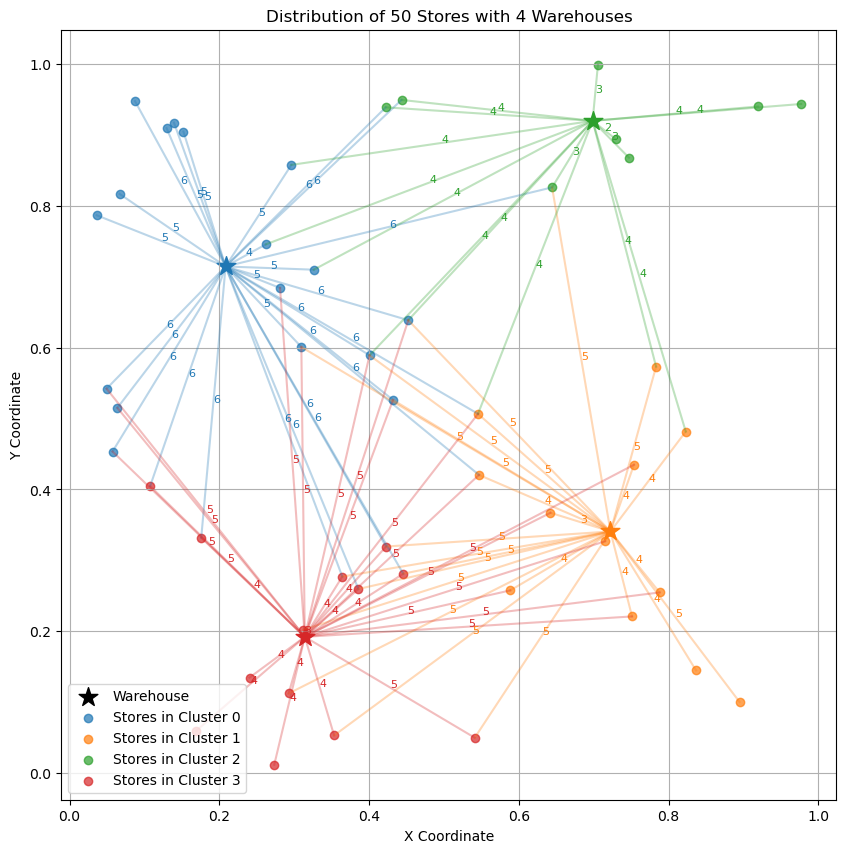

In [2]:
import pandas as pd
import numpy as np
import random
import math
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans

# -----------------------------
# Parameters
# -----------------------------
# N_STORES = 20  # Number of stores to sample
# N_WAREHOUSES = 2  # Number of warehouses
# np.random.seed(44)
# connection_distance_multiplier = 1.3


# N_STORES = 40  # Number of stores to sample
# N_WAREHOUSES = 3  # Number of warehouses
# np.random.seed(45)
# connection_distance_multiplier = 1.3

N_STORES = 50  # Number of stores to sample
N_WAREHOUSES = 4  # Number of warehouses
np.random.seed(77)
connection_distance_multiplier = 1.7

# -----------------------------
# 1. Generate random store locations
# -----------------------------
# Generate random coordinates between 0 and 1
x_coords = np.random.uniform(0, 1, N_STORES)
y_coords = np.random.uniform(0, 1, N_STORES)

# Create DataFrame with store locations
stores_df = pd.DataFrame({
    'store_nbr': range(N_STORES),
    'x': x_coords,
    'y': y_coords
})

# -----------------------------
# 2. Define distance function
# -----------------------------
def euclidean_distance(x1, y1, x2, y2):
    """Calculate Euclidean distance between two points"""
    return np.sqrt((x2 - x1)**2 + (y2 - y1)**2)

# -----------------------------
# 3. Clustering and plotting
# -----------------------------

# Primitive parameters
h0, h1 = 0.2, 0.4  # warehouse holding cost range
ml0, ml1 = 1, 3    # minimal lead time range
dl0, dl1 = 1, 3    # distance lead time range

# Create figure
plt.figure(figsize=(10, 10))

# Get store coordinates for clustering
coords = stores_df[['x', 'y']].values

# Run k-means clustering
kmeans = KMeans(n_clusters=N_WAREHOUSES, random_state=42)
labels = kmeans.fit_predict(coords)
centers = kmeans.cluster_centers_

# Add cluster labels to DataFrame
stores_df['cluster'] = labels

# Determine number of stores per cluster
cluster_counts = stores_df.groupby('cluster').size()
min_count = cluster_counts.min()
max_count = cluster_counts.max()

# For printing warehouse info
warehouse_info = []

# Calculate max distances for each cluster
max_distances = []
for cluster in range(N_WAREHOUSES):
    cluster_stores = stores_df[stores_df['cluster'] == cluster]
    center_x, center_y = centers[cluster]
    distances = [euclidean_distance(center_x, center_y, store['x'], store['y']) 
                for _, store in cluster_stores.iterrows()]
    max_dist = max(distances) if distances else 0
    max_distances.append(max_dist)

# For each warehouse (cluster)
connected_stores_count = [0] * N_WAREHOUSES
edges = np.zeros((N_WAREHOUSES, N_STORES))  # Matrix to store edges
lead_times = np.zeros((N_WAREHOUSES, N_STORES))  # Matrix to store lead times

for cluster in range(N_WAREHOUSES):
    cluster_stores = stores_df[stores_df['cluster'] == cluster]
    w_n = len(cluster_stores)
    
    # Compute normalized weight
    w_k = (w_n - min_count) / (max_count - min_count) if max_count != min_count else 1.0
    
    # Compute warehouse holding cost
    w_h = h0 + (h1 - h0) * (1 - w_k) if max_count != min_count else (h0 + h1) / 2
    
    # Get cluster center coordinates
    center_x, center_y = centers[cluster]
    
    # Find max distance in cluster for normalizing distances
    max_dist = max_distances[cluster]
    
    # Minimal lead time calculation
    ml_part = ml0 + (ml1 - ml0) * w_k if max_count != min_count else (ml0 + ml1) / 2
    
    warehouse_info.append({
        "warehouse": cluster,
        "stores": w_n,
        "holding_cost": w_h,
        "min_lead_time": ml_part
    })

    # Calculate edges and lead times
    for store_idx, store in stores_df.iterrows():
        dist = euclidean_distance(center_x, center_y, store['x'], store['y'])
        
        # Check if store should be connected
        if dist <= max_dist * connection_distance_multiplier:
            edges[cluster][store_idx] = 1
            connected_stores_count[cluster] += 1
            
            # Calculate lead time
            # Base lead time component
            base_lt = ml0 + (ml1 - ml0) * w_k
            # Distance-based lead time component
            dist_lt = dl0 + (dl1 - dl0) * min(1.0, dist/max_dist)
            # Total lead time (rounded up to integer)
            lead_times[cluster][store_idx] = np.round(base_lt + dist_lt)

# Print edges matrix
print("\nEdges matrix (warehouses x stores):")
print(str(edges.astype(int)).replace(' [', '[').replace('[[', '[\n [').replace(']]', ']\n]').replace(' ', ', '))

# Print lead times matrix
print("\nLead times matrix (warehouses x stores):")
print(str(lead_times.astype(int)).replace(' [', '[').replace('[[', '[\n [').replace(']]', ']\n]').replace(' ', ', '))

# Plotting
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd']

# First plot warehouse marker in legend
plt.scatter([], [], c='black', marker='*', s=200, label='Warehouse')

# Plot stores and connections
for cluster in range(N_WAREHOUSES):
    color = colors[cluster % len(colors)]
    cluster_data = stores_df[stores_df['cluster'] == cluster]
    center_x, center_y = centers[cluster]
    
    # Plot stores
    plt.scatter(cluster_data['x'], cluster_data['y'], 
                color=color, alpha=0.7, label=f'Stores in Cluster {cluster}')
    
    # Plot warehouse
    plt.scatter(center_x, center_y, c=color, marker='*', s=200)
    
    # Plot connections and lead times
    for store_idx, store in stores_df.iterrows():
        if edges[cluster][store_idx] == 1:
            plt.plot([center_x, store['x']], [center_y, store['y']], 
                     color=color, alpha=0.3, linestyle='-')
            # Add lead time text at midpoint of connection line
            mid_x = (center_x + store['x']) / 2
            mid_y = (center_y + store['y']) / 2
            plt.text(mid_x, mid_y, f"{int(lead_times[cluster][store_idx])}", 
                    color=color, fontsize=8)

plt.xlabel("X Coordinate")
plt.ylabel("Y Coordinate")
plt.title(f"Distribution of {N_STORES} Stores with {N_WAREHOUSES} Warehouses")
plt.legend()
plt.grid(True)

print(f"\nWarehouse Statistics:")
for info, connected_count in zip(warehouse_info, connected_stores_count):
    print(f" Warehouse {info['warehouse']}: #Stores = {info['stores']}, "
          f"Connected stores = {connected_count}, "
          f"min lead time = {info['min_lead_time']:.2f}, "
          f"holding cost = {info['holding_cost']:.2f}")

plt.show()


In [13]:
stores_df

,store_nbr,x,y,cluster
0,0,0.834842,0.636832,0
1,1,0.104796,0.139146,1
2,2,0.744640,0.458704,0
3,3,0.360501,0.873863,0
4,4,0.359311,0.258450,1
5,5,0.609238,0.664851,0
6,6,0.393780,0.862674,0
7,7,0.409073,0.148848,1
8,8,0.509902,0.562950,0
9,9,0.710148,0.159155,1


In [14]:
lead_times = [[4, 4, 4, 4, 4, 4, 4, 5, 4, 4, 4, 4, 5, 4, 4, 5, 5, 5, 6, 5, 5, 5, 5, 5,
               5, 5, 6, 6, 5, 6, 5, 6, 6, 5, 5, 4, 4, 4, 4, 4, 4, 5, 5, 5, 5, 5],
              [5, 5, 5, 4, 5, 4, 4, 4, 5, 4, 5, 5, 4, 5, 4, 4, 4, 3, 3, 3, 3, 3, 3, 3,
               4, 3, 3, 3, 4, 4, 4, 4, 4, 4, 5, 5, 5, 5, 5, 5, 5, 4, 3, 4, 4, 4],
              [3, 3, 3, 3, 4, 3, 3, 3, 4, 3, 3, 3, 3, 4, 3, 3, 3, 2, 3, 2, 3, 2, 3, 2,
               3, 2, 2, 3, 2, 2, 2, 2, 2, 2, 4, 3, 3, 3, 3, 4, 3, 3, 2, 3, 3, 3],
              [3, 3, 3, 3, 3, 3, 3, 3, 4, 3, 3, 3, 3, 3, 3, 3, 2, 3, 4, 3, 3, 3, 3, 3,
               3, 3, 4, 4, 4, 4, 3, 4, 4, 3, 4, 3, 3, 3, 3, 3, 3, 2, 3, 4, 4, 3]]
edges = [[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0,
               1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1],
              [0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1,
               1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0],
              [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0,
               0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
              [0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0,
               1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0]]
# Make lead time 0 if edge doesn't exist
for warehouse_idx in range(len(edges)):
    for store_idx in range(len(edges[warehouse_idx])):
        if edges[warehouse_idx][store_idx] == 0:
            lead_times[warehouse_idx][store_idx] = 0

# Merge lead times into a single list, taking the smallest non-zero value
merged_lead_times = []
for store_idx in range(len(lead_times[0])):
    # Get non-zero lead times for this store
    store_lead_times = [lt[store_idx] for lt in lead_times if lt[store_idx] != 0]
    # If there are any non-zero lead times, take minimum, otherwise use 0
    merged_lead_times.append(min(store_lead_times) if store_lead_times else 0)


# Merge edges into a single list where 1 indicates connection to either warehouse
merged_edges = []
for store_idx in range(len(edges[0])):
    # If store is connected to either warehouse (has edge value of 1), set merged value to 1
    merged_edges.append(1 if any(edges[w][store_idx] == 1 for w in range(len(edges))) else 0)

print("\nLead times:")
print(merged_lead_times)
print("\nEdges:")
print(merged_edges)


Lead times:
[4, 4, 4, 3, 4, 3, 3, 3, 4, 4, 3, 3, 3, 4, 4, 3, 2, 2, 3, 2, 3, 3, 3, 3, 3, 3, 3, 3, 2, 2, 2, 2, 2, 2, 5, 4, 3, 3, 4, 4, 3, 2, 3, 4, 4, 5]

Edges:
[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]


In [18]:
import os
def create_n_warehouse_config_file(old_config, new_config, option=None):
    new_config_path = f'/user/ml4723/Prj/NIC/config_files/settings/{new_config}.yml'
    # if not os.path.exists(new_config_path):
    with open(f'/user/ml4723/Prj/NIC/config_files/settings/{old_config}.yml', 'r') as src:
        with open(new_config_path, 'w') as dst:
            dst.write(src.read())

    # Load the yml file and extract edge data
    import yaml
    with open(new_config_path, 'r') as f:
        config = yaml.safe_load(f)
        edge_lead_times = config['warehouse_params']['edge_lead_times']['value']
        edges = config['warehouse_params']['edges']['value']
    
    # For each store, find the warehouse with smallest lead time and keep only that connection
    n_warehouses = len(edges)
    n_stores = len(edges[0])
    
    # Create new edge and lead time arrays
    new_edges = [[0 for _ in range(n_stores)] for _ in range(n_warehouses)]
    new_lead_times = [[0 for _ in range(n_stores)] for _ in range(n_warehouses)]
    
    if option == "fastest":
        # For each store
        for store in range(n_stores):
            min_lead_time = float('inf')
            best_warehouse = None
            
            # Find warehouse with smallest lead time that has a connection
            for warehouse in range(n_warehouses):
                if edges[warehouse][store] == 1:
                    if edge_lead_times[warehouse][store] < min_lead_time:
                        min_lead_time = edge_lead_times[warehouse][store]
                        best_warehouse = warehouse
            
            # Keep only connection to best warehouse
            if best_warehouse is not None:
                new_edges[best_warehouse][store] = 1
                new_lead_times[best_warehouse][store] = edge_lead_times[best_warehouse][store]
    
    # Update config with new values
    config['warehouse_params']['edge_lead_times']['value'] = new_lead_times
    config['warehouse_params']['edges']['value'] = new_edges
    
    # Save updated config with proper formatting
    with open(new_config_path, 'w') as f:
        yaml.dump(config, f, default_flow_style=True, width=float('inf'))
        
    return new_lead_times, new_edges

edge_lead_times, edges = create_n_warehouse_config_file('n_warehouse_46_1_real_lost_demand', 'n_warehouse_46_1_real_lost_demand_fastest', "fastest")

In [19]:
edge_lead_times

[[4,
  4,
  4,
  4,
  4,
  3,
  3,
  3,
  4,
  4,
  4,
  4,
  3,
  4,
  4,
  4,
  3,
  4,
  4,
  4,
  4,
  4,
  3,
  4,
  3,
  4,
  4,
  4,
  4,
  5,
  4,
  4,
  5,
  4,
  5,
  4,
  4,
  4,
  4,
  4,
  4,
  3,
  4,
  4,
  4,
  4]]

Total selected stores: 46


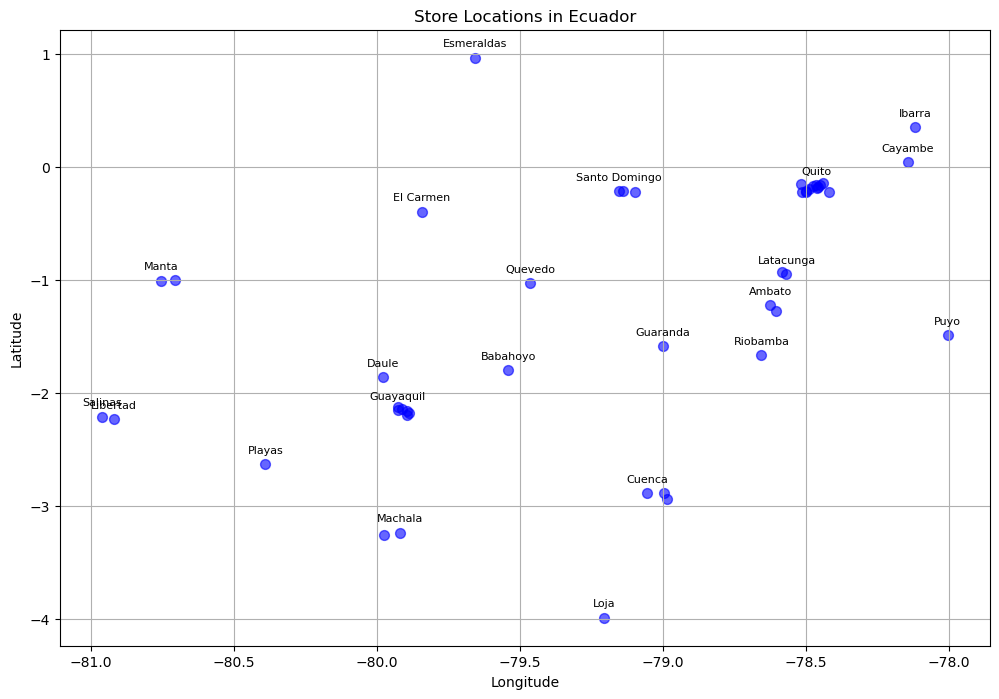

In [3]:
import pandas as pd
import numpy as np
import random
import math
import matplotlib.pyplot as plt

# -----------------------------
# 1. Define store data and selection
# -----------------------------

# Create a DataFrame for the 54 stores
data = [
    [1, "Quito", "Pichincha", "D", 13],
    [2, "Quito", "Pichincha", "D", 13],
    [3, "Quito", "Pichincha", "D", 8],
    [5, "Santo Domingo", "Santo Domingo de los Tsachilas", "D", 4],
    [11, "Cayambe", "Pichincha", "B", 6],
    [12, "Latacunga", "Cotopaxi", "C", 15],
    [13, "Latacunga", "Cotopaxi", "C", 15],
    [14, "Riobamba", "Chimborazo", "C", 7],
    [15, "Ibarra", "Imbabura", "C", 15],
    [16, "Santo Domingo", "Santo Domingo de los Tsachilas", "C", 3],
    [17, "Quito", "Pichincha", "C", 12],
    [18, "Quito", "Pichincha", "B", 16],
    [19, "Guaranda", "Bolivar", "C", 15],
    [20, "Quito", "Pichincha", "B", 6],
    [21, "Santo Domingo", "Santo Domingo de los Tsachilas", "B", 6],
    [22, "Puyo", "Pastaza", "C", 7],
    [23, "Ambato", "Tungurahua", "D", 9],
    [24, "Guayaquil", "Guayas", "D", 1],
    [25, "Salinas", "Santa Elena", "D", 1],
    [26, "Guayaquil", "Guayas", "D", 10],
    [27, "Daule", "Guayas", "D", 1],
    [30, "Guayaquil", "Guayas", "C", 3],
    [31, "Babahoyo", "Los Rios", "B", 10],
    [32, "Guayaquil", "Guayas", "C", 3],
    [33, "Quevedo", "Los Rios", "C", 3],
    [34, "Guayaquil", "Guayas", "B", 6],
    [35, "Playas", "Guayas", "C", 3],
    [36, "Libertad", "Guayas", "E", 10],
    [37, "Cuenca", "Azuay", "D", 2],
    [38, "Loja", "Loja", "D", 4],
    [39, "Cuenca", "Azuay", "B", 6],
    [40, "Machala", "El Oro", "C", 3],
    [41, "Machala", "El Oro", "D", 4],
    [42, "Cuenca", "Azuay", "D", 2],
    [43, "Esmeraldas", "Esmeraldas", "E", 10],
    [44, "Quito", "Pichincha", "A", 5],
    [45, "Quito", "Pichincha", "A", 11],
    [46, "Quito", "Pichincha", "A", 14],
    [47, "Quito", "Pichincha", "A", 14],
    [48, "Quito", "Pichincha", "A", 14],
    [49, "Quito", "Pichincha", "A", 11],
    [50, "Ambato", "Tungurahua", "A", 14],
    [51, "Guayaquil", "Guayas", "A", 17],
    [52, "Manta", "Manabi", "A", 11],
    [53, "Manta", "Manabi", "D", 13],
    [54, "El Carmen", "Manabi", "C", 3]
]
columns = ["store_nbr", "city", "state", "type", "cluster"]
stores_df = pd.DataFrame(data, columns=columns)

# Group stores by city
city_groups = stores_df.groupby("city")
# Find cities with >1 store (multi-store) and with exactly 1 store (single-store)
multi_store_cities = [city for city, group in city_groups if len(group) > 1]
single_store_cities = [city for city, group in city_groups if len(group) == 1]

# Use all stores since data already has 46 stores
selected_stores = stores_df.reset_index(drop=True)
print("Total selected stores:", len(selected_stores))

# -----------------------------
# 2. Assign coordinates based on city centers
# -----------------------------
# Original dictionary: keys are city names, values are (lon, lat) tuples
city_coords = {
    "Esmeraldas": (-79.6545, 0.9682),
    "Ibarra": (-78.1165, 0.3517),
    "Cayambe": (-78.1416, 0.0412),
    "Quito": (-78.4678, -0.1807),
    "Santo Domingo": (-79.1459, -0.253),
    "Manta": (-80.7214, -0.9682),
    "Latacunga": (-78.6131, -0.9352),
    "El Carmen": (-79.8413, -0.3944),
    "Quevedo": (-79.4632, -1.0281),
    "Puyo": (-78.0035, -1.4921),
    "Ambato": (-78.6197, -1.2491),
    "Riobamba": (-78.6546, -1.6636),
    "Babahoyo": (-79.5400, -1.8022),
    "Daule": (-79.9775, -1.8619),
    "Guayaquil": (-79.8891, -2.1709),
    "Libertad": (-80.9182, -2.2333),
    "Playas": (-80.3895, -2.6333),
    "Salinas": (-80.9607, -2.2117),
    "Cuenca": (-79.0059, -2.9006),
    "Machala": (-79.9616, -3.2581),
    "Loja": (-79.2050, -3.9931),
    "Guaranda": (-79.0000, -1.5900),
}

rng = np.random.RandomState(0)  # Fixed seed for reproducibility

# Function to add random noise (simulate dispersion within a city's area)
def random_location(city, noise=0.05):  # noise in degrees
    if city in city_coords:
        base_lon, base_lat = city_coords[city]
        # Only add noise if city has multiple stores
        if city in multi_store_cities:
            lon = base_lon + rng.uniform(-noise, noise)
            lat = base_lat + rng.uniform(-noise, noise)
        else:
            lon, lat = base_lon, base_lat
        return lon, lat
    else:
        return np.nan, np.nan

# Assign coordinates for each store
lons, lats = [], []
for idx, row in selected_stores.iterrows():
    lon, lat = random_location(row["city"])
    lons.append(lon)
    lats.append(lat)
selected_stores["lon"] = lons
selected_stores["lat"] = lats

# Create the plot
plt.figure(figsize=(12, 8))

# Plot each store location
plt.scatter(selected_stores["lon"], selected_stores["lat"], c='blue', alpha=0.6, s=50)

# Add city names as labels
labeled_cities = set()
for _, store in selected_stores.iterrows():
    if store["city"] not in labeled_cities:
        plt.annotate(store["city"], 
                    (store["lon"], store["lat"]),
                    fontsize=8,
                    ha='center',
                    va='center',
                    xytext=(0, 10),
                    textcoords='offset points')
        labeled_cities.add(store["city"])

plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.title("Store Locations in Ecuador")
plt.grid(True)
plt.show()
